原文连接：https://tensorflow.google.cn/tutorials/estimators/linear#converting_data_into_tensors

# 概述

我们会使用包含个人年龄、受教育程度、婚姻状况和职业（即特征）数据在内的普查数据，尝试预测个人年收入是否超过 5 万美元（即目标标签）。我们会训练一个逻辑回归模型，若给出某个人的信息，该模型会输出一个介于 0 到 1 之间的值，可将该值解读为个人年收入超过 5 万美元的概率。

要点：作为建模者兼开发者，需要考虑如何使用这些数据，以及模型预测可能会带来哪些潜在益处和危害。类似这样的模型可能会加深社会偏见，扩大社会差异。每个特征是否与您要解决的问题相关，或者是否会引入偏见？要了解详情，请参阅机器学习公平性。

# 设置

### 导入TF、特征列等

In [0]:
import tensorflow as tf
import tensorflow.feature_column as fc

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

然后启用 Eager Execution，以在此程序运行时检查此程序

In [0]:
tf.enable_eager_execution()

### 下载官方实现

下载代码、将根目录添加到 Python 路径，然后跳转到 wide_deep 目录

In [4]:
! pip install -q requests
! git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


将该代码库的根目录添加到python路径

In [0]:
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

下载数据集

In [6]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/tmp/census_data/")

W0726 16:07:41.731217 140211390670720 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:78: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0726 16:07:41.732929 140211390670720 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:81: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



### 命令行用法

要从命令行执行教程代码，先将 tensorflow/models 路径添加到您的 PYTHONPATH。

In [0]:
#export PYTHONPATH=${PYTHONPATH}:"$(pwd)/models"
#running from python you need to set the `os.environ` or the subprocess will not see the directory.

if "PYTHONPATH" in os.environ:
  os.environ['PYTHONPATH'] += os.pathsep +  models_path
else:
  os.environ['PYTHONPATH'] = models_path

使用 --help 查看可用的命令行选项：

In [8]:
!python -m official.wide_deep.census_main --help

W0726 16:07:46.580484 139866863912832 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0726 16:07:46.580805 139866863912832 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

Train DNN on census income dataset.
flags:

/content/models/official/wide_deep/census_main.py:
  -bs,--batch_size:
    Batch size for training and evaluation. When using multiple gpus, this is
    the
    global batch size for all devices. For example, if the batch size is 32 and
    there are 4 GPUs, each GPU will get 8 examples on each step.
    (default: '40')
    (an integer)
  --[no]clean:
    If set, model_dir will be removed if it exists.
    (default: 'false')
  -dd,--data_dir:
    The location of the input data.
    (default: '/tmp/census_da

运行模型

In [9]:
!python -m official.wide_deep.census_main --model_type=wide --train_epochs=2

W0726 16:07:53.624871 140370283140992 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0726 16:07:53.625213 140370283140992 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0726 16:07:53.628177 140370283140992 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:78: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0726 16:07:53.628396 140370283140992 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:81: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0726 16:07:53.629406 140370283140992 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:49: The name tf

### 读取数据

In [0]:
train_file = "/tmp/census_data/adult.data"
test_file = "/tmp/census_data/adult.test"

pandas 提供了一些便捷的数据分析实用工具

In [11]:
import pandas

train_df = pandas.read_csv(train_file, header = None, names = census_dataset._CSV_COLUMNS)
test_df = pandas.read_csv(test_file, header = None, names = census_dataset._CSV_COLUMNS)

train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 将数据转换为张量

#### 数据集一般传输

In [0]:
def easy_input_function(df, label_key, num_epochs, shuffle, batch_size):
  label = df[label_key]
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  ds = ds.batch(batch_size).repeat(num_epochs)

  return ds

已启用 Eager Execution，因此可轻松检查生成的数据集：

In [13]:
ds = easy_input_function(train_df, label_key='income_bracket', num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys())[:5])
  print()
  print('A batch of Ages  :', feature_batch['age'])
  print()
  print('A batch of Labels:', label_batch )

Some feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

A batch of Ages  : tf.Tensor([48 33 40 49 47 41 22 26 18 59], shape=(10,), dtype=int32)

A batch of Labels: tf.Tensor(
[b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'>50K' b'<=50K' b'<=50K' b'<=50K'
 b'<=50K' b'<=50K'], shape=(10,), dtype=string)


#### 数据集从磁盘流式传输

In [14]:
import inspect
print(inspect.getsource(census_dataset.input_fn))

def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)

  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = 

此`input_fn`与一般返回等效

In [15]:
ds = census_dataset.input_fn(train_file, num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Feature keys:', list(feature_batch.keys())[:5])
  print()
  print('Age batch   :', feature_batch['age'])
  print()
  print('Label batch :', label_batch )

W0726 16:08:15.232205 140211390670720 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:167: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W0726 16:08:15.233481 140211390670720 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:168: The name tf.decode_csv is deprecated. Please use tf.io.decode_csv instead.



Feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

Age batch   : tf.Tensor([49 33 51 32 27 53 50 48 22 46], shape=(10,), dtype=int32)

Label batch : tf.Tensor([ True False False False  True False False  True False  True], shape=(10,), dtype=bool)


因为 Estimators 要求 input_fn 不接受任何参数。将可配置的输入函数封装到带预期签名的对象中。对于此笔记，配置 train_inpf 以迭代数据两次：

In [0]:
import functools

train_inpf = functools.partial(census_dataset.input_fn, train_file, num_epochs=2, shuffle=True, batch_size=64)
test_inpf = functools.partial(census_dataset.input_fn, test_file, num_epochs=1, shuffle=False, batch_size=64)

### 为模型选择特征并进行特征工程处理

#### 基准特征列

##### 数值列

最简单的 feature_column 是 numeric_column。它表示特征是数值，应直接输入到模型中。例如：

In [0]:
age = fc.numeric_column('age')

模型将使用 feature_column 定义来构建模型输入。您可以使用 input_layer 函数检查生成的输出：

In [18]:
fc.input_layer(feature_batch, [age]).numpy()

W0726 16:08:15.399683 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: NumericColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:15.402817 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:15.406165 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_c

array([[49.],
       [33.],
       [51.],
       [32.],
       [27.],
       [53.],
       [50.],
       [48.],
       [22.],
       [46.]], dtype=float32)

以下代码将仅使用 age 特征训练和评估模型：

In [19]:
classifier = tf.estimator.LinearClassifier(feature_columns=[age])
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()  # used for display in notebook
print(result)

{'accuracy': 0.7562189, 'accuracy_baseline': 0.76377374, 'auc': 0.67835647, 'auc_precision_recall': 0.3113917, 'average_loss': 0.5235813, 'label/mean': 0.23622628, 'loss': 33.429127, 'precision': 0.16756757, 'prediction/mean': 0.25417745, 'recall': 0.008060322, 'global_step': 1018}


我们可以为要在模型中使用的每个连续特征列定义 NumericColumn：

In [20]:
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = tf.feature_column.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = tf.feature_column.numeric_column('hours_per_week')

my_numeric_columns = [age,education_num, capital_gain, capital_loss, hours_per_week]

fc.input_layer(feature_batch, my_numeric_columns).numpy()

array([[  49., 7688.,    0.,    9.,   55.],
       [  33.,    0.,    0.,   10.,   40.],
       [  51.,    0.,    0.,    9.,   40.],
       [  32.,    0.,    0.,    9.,   40.],
       [  27.,    0.,    0.,    9.,   65.],
       [  53., 4650.,    0.,   10.,   40.],
       [  50.,    0.,    0.,   13.,   36.],
       [  48.,    0.,    0.,   13.,   40.],
       [  22.,    0.,    0.,   13.,   40.],
       [  46.,    0.,    0.,   14.,   40.]], dtype=float32)

可以通过更改构造函数的 feature_columns 参数，用这些特征重新训练模型：

In [21]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.7812788
accuracy_baseline: 0.76377374
auc: 0.78275555
auc_precision_recall: 0.559455
average_loss: 1.947678
global_step: 1018
label/mean: 0.23622628
loss: 124.35351
precision: 0.5683453
prediction/mean: 0.30738357
recall: 0.30811232


##### 类别列

要为类别特征定义特征列，请使用其中一个 tf.feature_column.categorical_column* 函数创建 CategoricalColumn。

In [0]:
relationship = fc.categorical_column_with_vocabulary_list(
    'relationship',
    ['Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'])

运行使用 age 和 relationship 列进行配置的输入层：

In [23]:
fc.input_layer(feature_batch, [age, fc.indicator_column(relationship)])

W0726 16:08:31.017069 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: IndicatorColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:31.019406 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:31.021466 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/featu

<tf.Tensor: id=5099, shape=(10, 7), dtype=float32, numpy=
array([[49.,  1.,  0.,  0.,  0.,  0.,  0.],
       [33.,  0.,  0.,  0.,  0.,  1.,  0.],
       [51.,  1.,  0.,  0.,  0.,  0.,  0.],
       [32.,  0.,  0.,  0.,  0.,  0.,  1.],
       [27.,  1.,  0.,  0.,  0.,  0.,  0.],
       [53.,  0.,  0.,  0.,  0.,  0.,  1.],
       [50.,  0.,  0.,  0.,  0.,  1.,  0.],
       [48.,  1.,  0.,  0.,  0.,  0.,  0.],
       [22.,  0.,  0.,  0.,  1.,  0.,  0.],
       [46.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)>

如果我们事先不知道可能值的集合，请改用 categorical_column_with_hash_bucket：

In [0]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)

在本示例中，我们在训练中看到的特征列 occupation 中的每个可能值都已经过哈希处理，变成整数 ID。以下示例批次包含几种不同的职业：

In [25]:
for item in feature_batch['occupation'].numpy():
    print(item.decode())

Exec-managerial
Exec-managerial
Protective-serv
Adm-clerical
Sales
Adm-clerical
Prof-specialty
Exec-managerial
Adm-clerical
Exec-managerial


如果我们使用经过哈希处理的列运行 input_layer，则看到输出形状为 (batch_size, hash_bucket_size)：

In [26]:
occupation_result = fc.input_layer(feature_batch, [fc.indicator_column(occupation)])

occupation_result.numpy().shape

W0726 16:08:31.071437 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4236: HashedCategoricalColumn._get_sparse_tensors (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:31.074429 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: HashedCategoricalColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:31.078523 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/pytho

(10, 1000)

如果我们对 hash_bucket_size 维度执行 tf.argmax 操作，则更容易看到实际结果。请注意，所有重复的职业都映射到相同的伪随机索引：

In [27]:
tf.argmax(occupation_result, axis=1).numpy()

array([800, 800, 684,  96, 631,  96, 979, 800,  96, 800])

我们可以使用类似的技巧定义其他类别特征：

In [0]:
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])

my_categorical_columns = [relationship, occupation, education, marital_status, workclass]

使用以上两组列可轻松配置使用所有这些特征的模型：

In [29]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns+my_categorical_columns)
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.83225846
accuracy_baseline: 0.76377374
auc: 0.8775589
auc_precision_recall: 0.65132797
average_loss: 1.8704863
global_step: 1018
label/mean: 0.23622628
loss: 119.42505
precision: 0.6550765
prediction/mean: 0.2530076
recall: 0.6123245


#### 衍生特征列

通过分桶将连续特征变成类别特征

如果我们要分别学习收入与各个年龄段之间的精细关系，则可以采用分桶技巧。分桶是将整个连续特征范围分割为一组连续分桶，然后根据值所在的分桶将原数值特征转换为分桶 ID（作为类别特征）的过程。因此，我们可以针对 age 将 bucketized_column 定义为：

In [0]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

boundaries 是分桶边界列表。本示例中有 10 个边界，因此会生成 11 个年龄段分桶（17 岁及以下、18-24 岁、25-29 岁、…，以及 65 岁及以上）。

通过分桶，模型将每个分桶视为一个独热特征：

In [31]:
fc.input_layer(feature_batch, [age, age_buckets]).numpy()

W0726 16:08:43.146164 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: BucketizedColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:43.147512 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: BucketizedColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0726 16:08:43.150929 140211390670720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/fea

array([[49.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [33.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [32.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [27.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [53.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [48.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [22.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [46.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],
      dtype=float32)

通过组合列学习复杂关系

要了解各个特征组合之间的差异，我们可以向模型中添加组合特征列

In [0]:
education_x_occupation = tf.feature_column.crossed_column(
    ['education', 'occupation'], hash_bucket_size=1000)

我们还可以针对两个以上的列创建一个 crossed_column。每个组成列可以是类别基准特征列 (SparseColumn)、分桶实值特征列，也可以是其他 CrossColumn。例如：

In [0]:
age_buckets_x_education_x_occupation = tf.feature_column.crossed_column(
    [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)

### 定义逻辑回归模型

处理输入数据并定义所有特征列后，我们可以将它们整合在一起，并构建逻辑回归模型。上一部分介绍了几类基准特征列和衍生特征列，包括：

- CategoricalColumn
- NumericColumn
- BucketizedColumn
- CrossedColumn

所有这些列都是抽象 FeatureColumn 类的子类，并且可添加到模型的 feature_columns 字段中：

In [0]:
import tempfile

base_columns = [
    education, marital_status, relationship, workclass, occupation,
    age_buckets,
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000),
]

model = tf.estimator.LinearClassifier(
    model_dir=tempfile.mkdtemp(),
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1))

模型会自动学习偏差项，偏差项可控制所进行的预测，而无需观察任何特征。学习的模型文件存储在 model_dir 中。

### 训练和评估模型

将所有特征添加到模型中后，开始训练模型。训练模型只需一个使用 tf.estimator API 的命令：

In [0]:
train_inpf = functools.partial(census_dataset.input_fn, train_file,
                               num_epochs=40, shuffle=True, batch_size=64)

model.train(train_inpf)

clear_output()  # used for notebook display

训练模型后，通过预测维持数据的标签来评估模型的准确率：

In [36]:
results = model.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %0.2f' % (key, value))

accuracy: 0.83
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.65
average_loss: 1.87
global_step: 1018.00
label/mean: 0.24
loss: 119.43
precision: 0.66
prediction/mean: 0.25
recall: 0.61


输出的第一行应显示诸如 accuracy: 0.83 的内容，表示准确率为 83%。您可以尝试使用更多特征和转换，看看能否取得更好的结果！

评估模型后，我们可以向模型输入某个人的信息，让其预测这个人的年收入是否超过 5 万美元。

我们来详细了解一下模型的表现：

In [37]:
import numpy as np

predict_df = test_df[:20].copy()

pred_iter = model.predict(
    lambda:easy_input_function(predict_df, label_key='income_bracket',
                               num_epochs=1, shuffle=False, batch_size=10))

classes = np.array(['<=50K', '>50K'])
pred_class_id = []

for pred_dict in pred_iter:
  pred_class_id.append(pred_dict['class_ids'])

predict_df['predicted_class'] = classes[np.array(pred_class_id)]
predict_df['correct'] = predict_df['predicted_class'] == predict_df['income_bracket']

clear_output()

predict_df[['income_bracket','predicted_class', 'correct']]

,income_bracket,predicted_class,correct
0,<=50K,<=50K,True
1,<=50K,<=50K,True
2,>50K,<=50K,False
3,>50K,<=50K,False
4,<=50K,<=50K,True
5,<=50K,<=50K,True
6,<=50K,<=50K,True
7,>50K,>50K,True
8,<=50K,<=50K,True
9,<=50K,<=50K,True


### 添加正则化以防止过拟合

正则化是用于避免过拟合的技术。

如果模型在训练数据上表现良好，但在从未见过的测试数据上表现糟糕，就表示发生了过拟合。

模型过于复杂（例如，相对于观察的训练数据量而言，采用的参数过多）会发生过拟合。

借助正则化，您能够控制模型的复杂度，并使模型能够更好地泛化到未见过的数据。

使用以下代码向模型中添加 L1 和 L2 正则化：

In [38]:
model_l1 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=10.0,
        l2_regularization_strength=0.0))

model_l1.train(train_inpf)

results = model_l1.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.56


In [39]:
model_l2 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.0,
        l2_regularization_strength=10.0))

model_l2.train(train_inpf)

results = model_l2.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.46
precision: 0.69
prediction/mean: 0.24
recall: 0.55


这些经过正则化的模型表现得并不比基准模型好很多。我们来看看模型的权重分布，以更好地了解正则化的影响：

In [0]:
def get_flat_weights(model):
  weight_names = [
      name for name in model.get_variable_names()
      if "linear_model" in name and "Ftrl" not in name]

  weight_values = [model.get_variable_value(name) for name in weight_names]

  weights_flat = np.concatenate([item.flatten() for item in weight_values], axis=0)

  return weights_flat

weights_flat = get_flat_weights(model)
weights_flat_l1 = get_flat_weights(model_l1)
weights_flat_l2 = get_flat_weights(model_l2)

模型中包含很多由未使用的哈希分箱所致的零值权重（在某些列中，哈希分箱的数量多于类别数量）。查看权重分布时，我们可以掩盖这些权重：

In [0]:
weight_mask = weights_flat != 0

weights_base = weights_flat[weight_mask]
weights_l1 = weights_flat_l1[weight_mask]
weights_l2 = weights_flat_l2[weight_mask]

现在，绘制分布图：

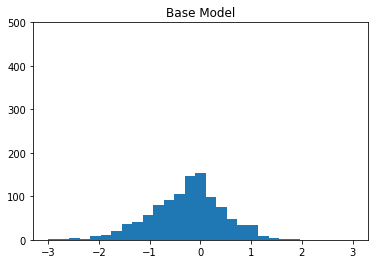

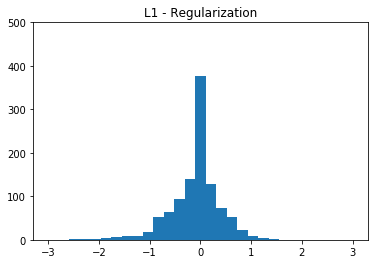

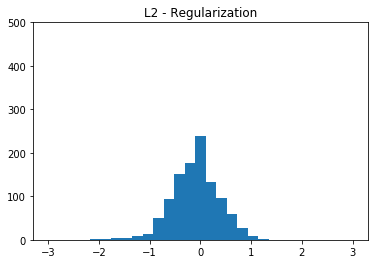

In [42]:
plt.figure()
_ = plt.hist(weights_base, bins=np.linspace(-3,3,30))
plt.title('Base Model')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l1, bins=np.linspace(-3,3,30))
plt.title('L1 - Regularization')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l2, bins=np.linspace(-3,3,30))
plt.title('L2 - Regularization')
_=plt.ylim([0,500])


这两种类型的正则化都使权重向零靠近，使其分布在零附近。L2 正则化对分布尾端的影响比较大，可消除极端权重。L1 正则化生成更多确切的零值，在本示例中，它将 ~200 设置为零值。